# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Minibatch size in the wine dataset
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [101]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-101-3e4a69c6af45>:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [102]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers



In [103]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [104]:
# z-score all columns except for quality
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [105]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
1,-0.298673,1.966614,-1.391823,0.049020,0.222827,0.877032,0.654661,0.025923,-0.723652,0.127837,-0.583341,-0.786623
2,-0.298673,1.295976,-1.185980,-0.165951,0.095334,-0.081247,0.246069,0.132100,-0.334209,-0.049176,-0.583341,-0.786623
3,1.653579,-1.386577,1.489975,-0.452579,-0.265897,0.110409,0.434650,0.662984,-0.983280,-0.462207,-0.583341,0.453492
4,-0.528350,0.960657,-1.391823,-0.452579,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623


# Re-organize the data: train/test in DataLoaders

In [106]:

# # create a new column for binarized (boolean) quality
# data['boolQuality'] = 0
# # data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
# data['boolQuality'][data['residual sugar']>2] = 1

In [107]:
# data['boolQuality'],

In [108]:
# convert from pandas dataframe to tensor
cols2zscore = cols2zscore.drop('residual sugar')
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

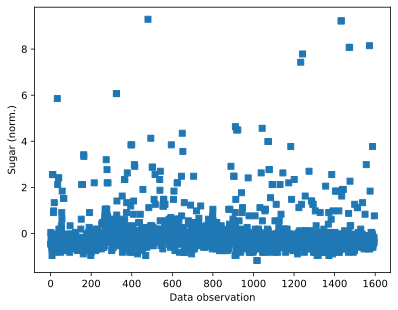

In [109]:
plt.plot(labels,'s')
plt.xlabel('Data observation')
plt.ylabel('Sugar (norm.)')
plt.show()

In [110]:
labels.shape, dataT.shape

(torch.Size([1597, 1]), torch.Size([1597, 11]))

In [111]:
dataT

tensor([[-0.5284,  0.9607, -1.3918,  ..., -0.5802, -0.9593, -0.7866],
        [-0.2987,  1.9666, -1.3918,  ...,  0.1278, -0.5833, -0.7866],
        [-0.2987,  1.2960, -1.1860,  ..., -0.0492, -0.5833, -0.7866],
        ...,
        [-1.1600, -0.1012, -0.7228,  ...,  0.5409,  0.5446,  0.4535],
        [-1.3896,  0.6533, -0.7743,  ...,  0.3048, -0.2074, -0.7866],
        [-1.3322, -1.2189,  1.0268,  ...,  0.0098,  0.5446,  0.4535]])

In [112]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# Now for the DL part

In [113]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.sigmoid( self.fc2(x) )
    return self.output(x)

# Train the model

In [114]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss() #MSE is used for regression, nn.BCEWithLogitsLoss() is used for binary classification
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    trainLoss[epochi] = np.mean(batchLoss)

    winenet.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = winenet(X)
    testLoss[epochi] = lossfun(yHat, y).item()


  # function output
  return trainLoss, testLoss

# Now for the experiment

In [115]:
# This cell takes ~15 mins

# range of batch sizes
batchsize = 32

test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset, batch_size=batchsize, shuffle=True, drop_last=True)

# create and train a model
winenet = ANNwine()
trainLoss,testLoss = trainTheModel()



In [116]:
trainLoss[:10]


tensor([1.0184, 0.9976, 1.0022, 1.0010, 0.9182, 0.9966, 0.9949, 0.9997, 0.9969,
        0.9846])

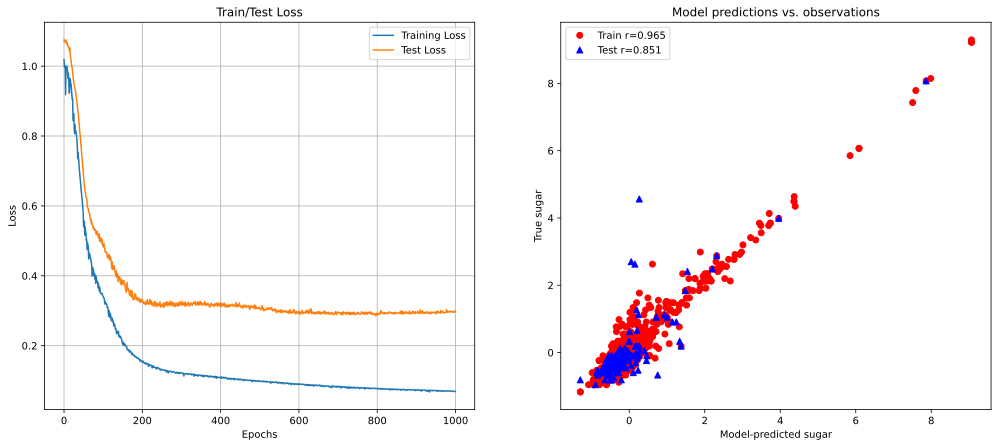

In [117]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(trainLoss, label="Training Loss")
ax[0].plot(testLoss, label="Test Loss")
ax[0].set_title('Train/Test Loss')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()

# show predictions and real values
yHatTrain = winenet(train_data)
yHatTest  = winenet(test_data)

ax[1].plot(yHatTrain.detach(),train_labels,'ro')
ax[1].plot(yHatTest.detach(),test_labels,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()
plt.show()

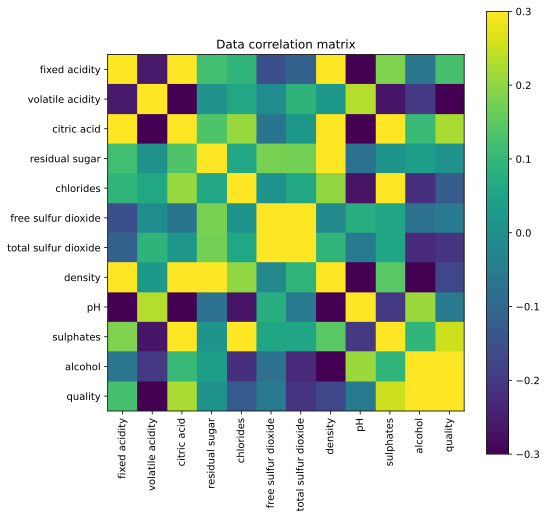

In [119]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()

# Additional explorations

In [118]:
# 1) There is another regularization technique called "early stopping," which simply means to stop training the model
#    earlier than the number of epochs you specified. Early stopping is used when the test accuracy starts to decrease
#    with increased training. Do you think that early stopping would be beneficial here? How many epochs would you train?
#
# 2) The training loop computes the losses, but those aren't plotted. Create an additional subplot to show the losses
#    in a similar fashion as the accuracy. Does that plot provide any additional insights into the effects of minibatch
#    size, beyond what we can already learn from the accuracy plots.
#